In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

2.10.1
2.10.0


In [3]:
import os
dataset = 'dataset//png'
data = [[ tf.keras.utils.img_to_array(tf.keras.utils.load_img(f'dataset//png//{f}', color_mode ="grayscale", target_size=(160, 320))), int(f[4:-4])] for f in sorted(os.listdir(dataset)) if os.path.isfile(os.path.join(dataset, f))]

In [4]:
import math
image_data, label_data = np.asarray([d[0] for d in data]), np.asarray([d[1]for d in data])
train_per_cent = 0.8
train_size = math.floor(len(data) * train_per_cent)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomTranslation((-0.001, 0.001), 0.1,  input_shape=(160, 320, 1), fill_mode='constant', fill_value=0.0),
  tf.keras.layers.RandomRotation((-0.001, 0.001)),
  tf.keras.layers.RandomZoom((0.001, 0.001), (0.01, 0.05)),
  tf.keras.layers.RandomBrightness(0.001),
])

train_dataset = image_data[:train_size, :, :]
train_dataset = np.asarray(data_augmentation(train_dataset))
test_dataset = np.asarray(image_data[train_size:, :, :])
train_labels = np.asarray(label_data[:train_size])
test_labels = np.asarray(label_data[train_size:])

In [9]:
#zapisywanie plików po augmentacji i eksporotwanie
import pickle
test_dataset_file = open('test_imgaes.pkl', 'ab')
pickle.dump(test_dataset, test_dataset_file)
test_dataset_file.close()
test_labels_file = open('test_labels.pkl', 'ab')
pickle.dump(test_labels, test_labels_file)
test_labels_file.close()

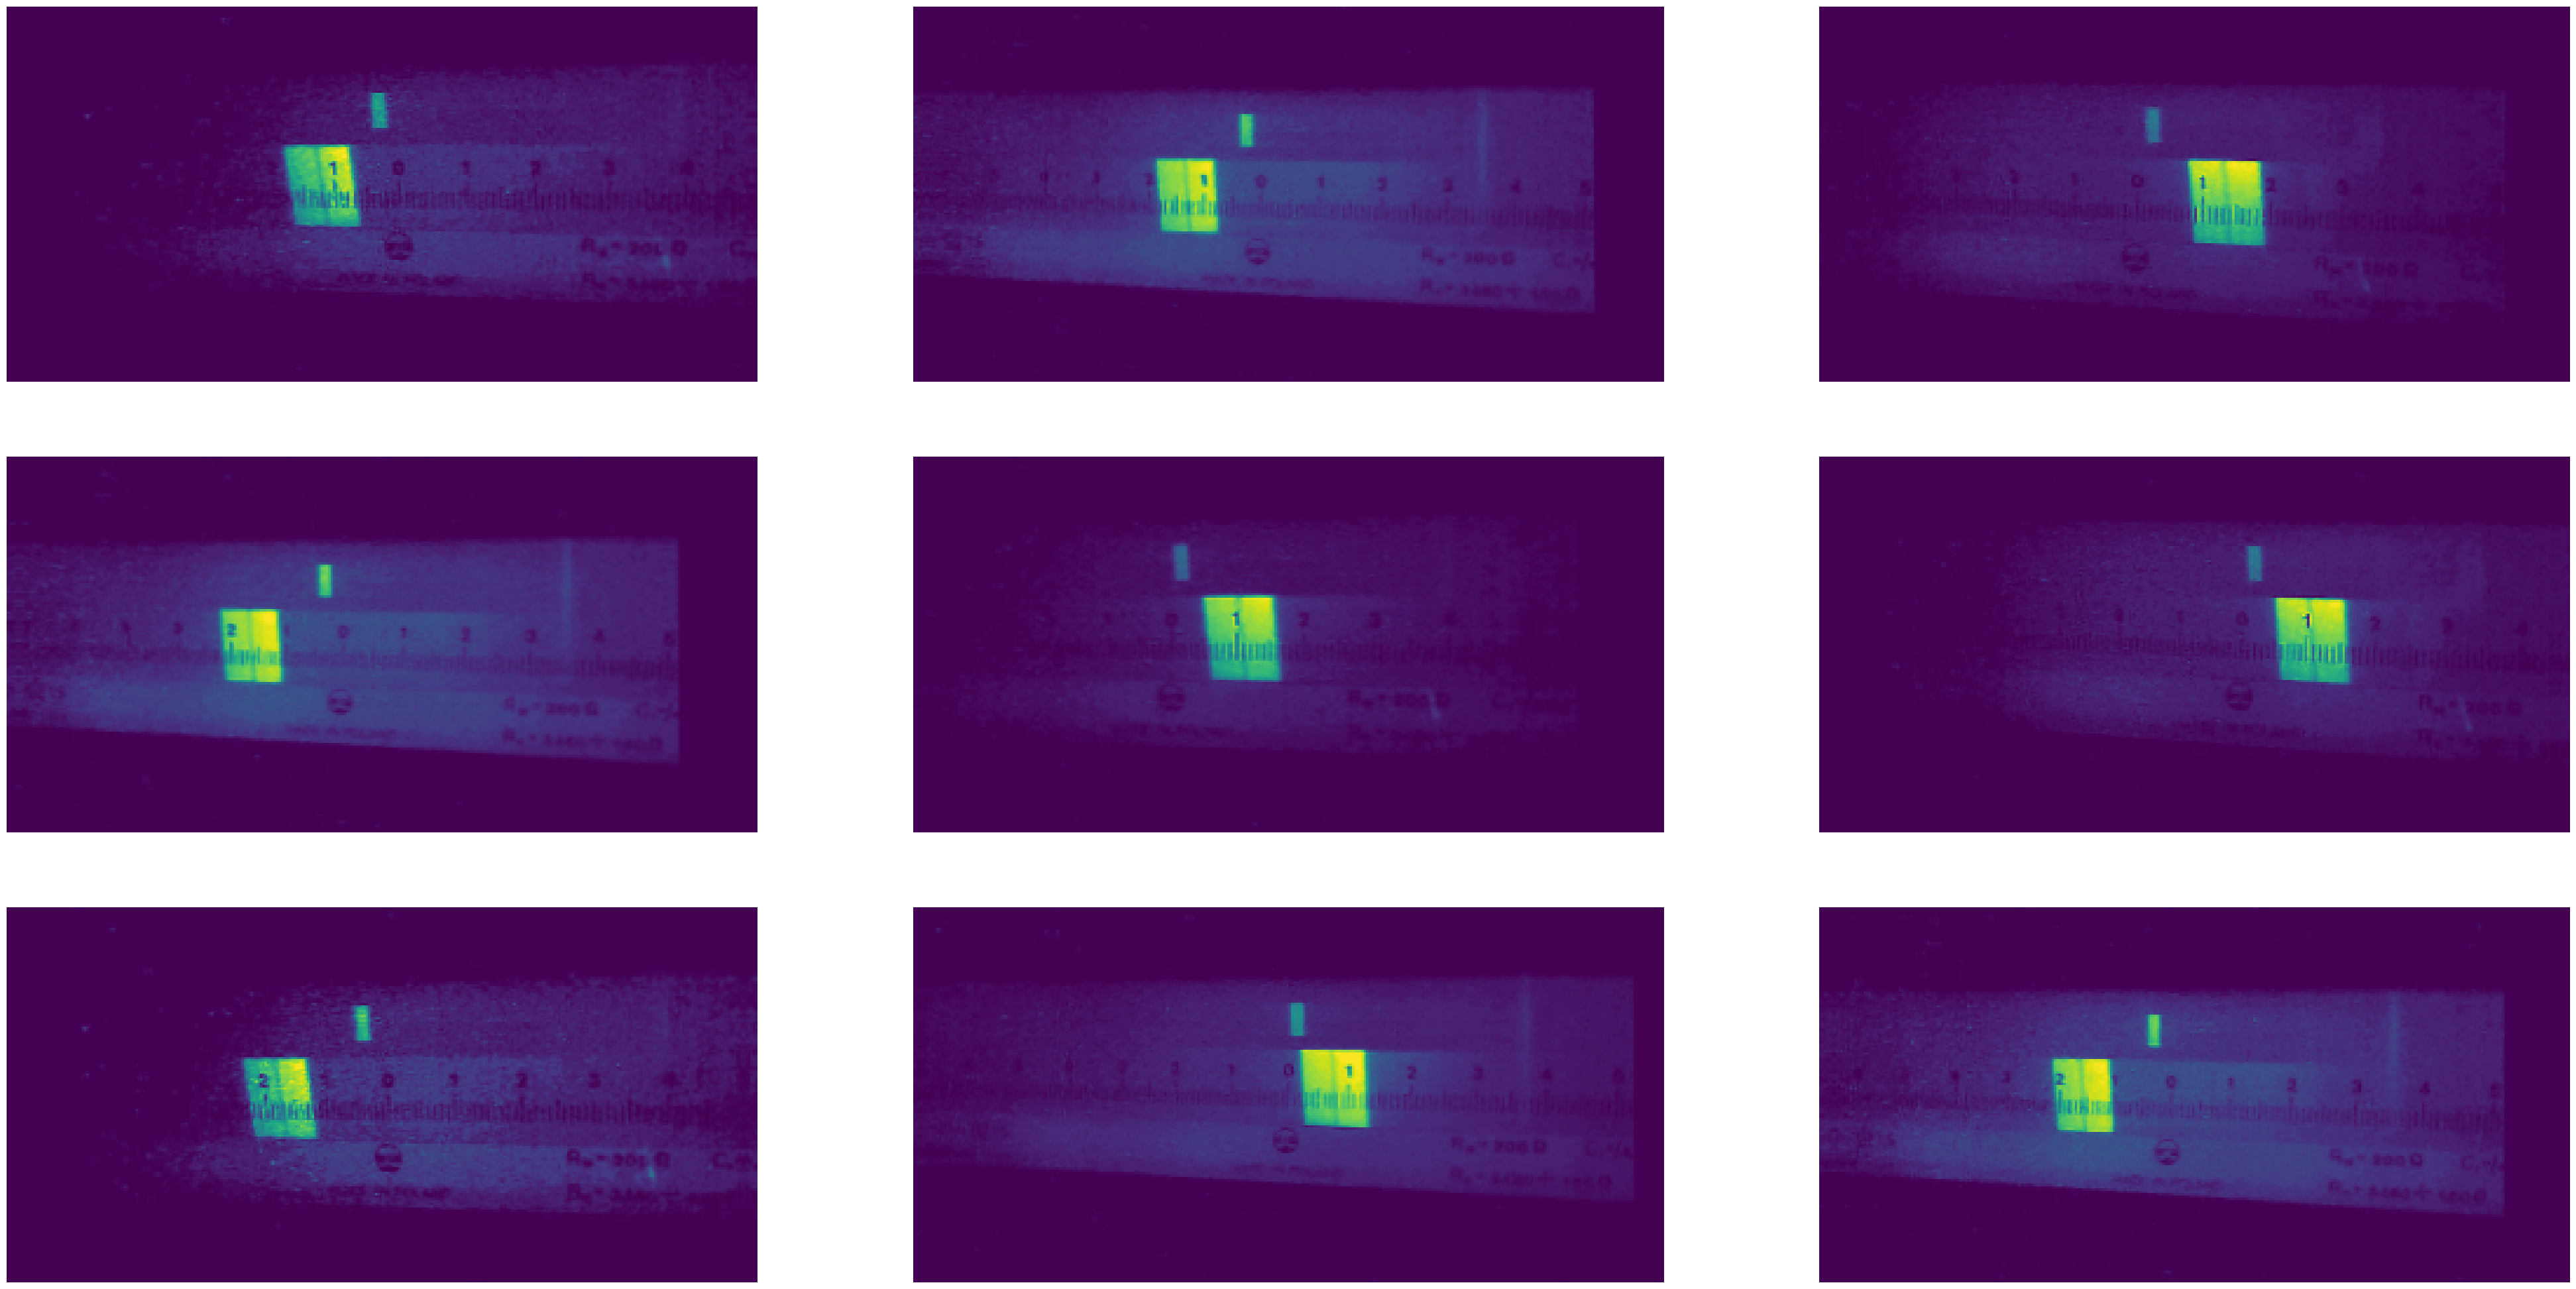

In [25]:
#przykładowe obrazy
import random
plt.figure(figsize=(50, 25))
for i in range(9):

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(random.choice(train_dataset))

    plt.axis("off")

In [ ]:
#tworzenie modelu
model = keras.Sequential([
    keras.layers.Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(160, 320, 1)),
    keras.layers.MaxPooling2D((4, 4)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, (4, 4), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((4, 4)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((4, 4)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2) ),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1),
])

model.compile(loss=tf.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adam(1e-6))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 320, 16)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 80, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 80, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 80, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 20, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 20, 32)       

In [12]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [13]:
train_gen = DataGenerator(train_dataset, train_labels, 1)
test_gen = DataGenerator(test_dataset, test_labels, 1)



In [ ]:
#trenowanie modelu
history = model.fit(
        train_dataset, train_labels,
        validation_split= 0.2,
        validation_data= (test_dataset, test_labels),
        batch_size=1,
        verbose=1, epochs=100)

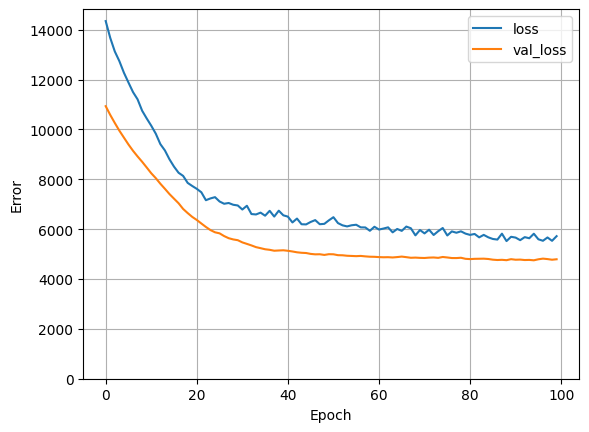

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim(bottom=0)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 320, 16)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 80, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 80, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 80, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 20, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 20, 32)       

In [14]:
test_loss = model.evaluate(test_gen, verbose=2)
print(test_loss)
print(test_loss ** 0.5)

167/167 - 1s - loss: 9114.9053 - 1s/epoch - 7ms/step
9114.9052734375
95.47201303752581


In [16]:
pre = model.predict(test_gen)
for (og, mg) in [*zip(test_labels, pre)]:
    print(og/100, mg[0]/100)

167/167 [==============================] - 1s 3ms/step
-0.7 -0.5100480651855469
0.7 0.3774033355712891
-0.7 -0.06541510581970215
-1.6 -0.4731487274169922
0.35 0.24929569244384767
-0.55 -0.44034175872802733
1.75 0.5118181228637695
0.2 0.36736354827880857
-0.1 0.05743448257446289
-1.0 -0.18692461013793946
1.2 0.4252971649169922
-0.45 -0.3555669403076172
0.2 -0.1481910228729248
1.45 0.672050552368164
1.35 0.46981201171875
0.2 -0.14356436729431152
0.05 0.3212285614013672
-2.1 -0.42275070190429687
-1.1 -0.2556951713562012
1.4 0.4011319351196289
0.6 0.5273063278198242
-0.8 -0.5183433532714844
-1.1 -0.21274658203125
1.7 0.6965408325195312
0.4 0.4324467086791992
0.6 0.02310948371887207
-0.7 -0.09433217048645019
-0.25 -0.029056684970855715
-0.35 -0.04787229537963867
-0.8 -0.24066865921020508
-0.65 -0.4791519927978516
-1.6 -0.46758872985839844
1.4 0.6791195678710937
1.5 0.6463565063476563
0.35 0.300051326751709
-0.75 -0.4779035186767578
0.8 0.5494001770019531
1.6 0.6580281066894531
0.75 0.153956

In [17]:
#zapisywanie modelu
model.save("my_model_27.keras")

In [20]:
my_model = keras.models.load_model("my_model_27.keras")

In [22]:
import tf2onnx
import onnx

In [23]:
#konwersja na .onnx
input_signature = [tf.TensorSpec(my_model.input.shape, my_model.input.dtype)]
onnx_model, _ = tf2onnx.convert.from_keras(my_model, input_signature, opset=13)

In [24]:
onnx.save(onnx_model, "my_model_27.onnx")